# Recommending Locations for an Italian Restaurant in Fort Worth

In [13]:
# package imports
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

## Data Collection

### Demographics

In [14]:
# API Endpoints for Fort Worth and National Data
fort_worth_url = "https://api.censusreporter.org/1.0/data/show/latest?geo_ids=16000US4827000&table_ids=B01003,B19013,B01002"
us_url = "https://api.censusreporter.org/1.0/data/show/latest?geo_ids=01000US&table_ids=B01003,B19013,B01002"

# Fetch data
fort_worth_data = requests.get(fort_worth_url).json()
us_data = requests.get(us_url).json()

# Extract key statistics
fort_worth_geo = fort_worth_data["data"]["16000US4827000"]
us_geo = us_data["data"]["01000US"]

# Land area values (Census QuickFacts)
fort_worth_land_area = 342.2  # Fort Worth land area (sq. miles)
us_land_area = 3531905  # US total land area (sq. miles)

# Calculate population density
fort_worth_population = fort_worth_geo["B01003"]["estimate"]["B01003001"]
us_population = us_geo["B01003"]["estimate"]["B01003001"]

fort_worth_density = fort_worth_population / fort_worth_land_area
us_density = us_population / us_land_area

# Convert to DataFrame
df = pd.DataFrame({
    "Metric": ["Median Household Income", "Median Age", "Population Density (per sq. mile)"],
    "Fort Worth": [
        fort_worth_geo["B19013"]["estimate"]["B19013001"],  # Fort Worth Median Income
        fort_worth_geo["B01002"]["estimate"]["B01002001"],  # Fort Worth Median Age
        round(fort_worth_density, 2)  # Fort Worth Population Density
    ],
    "National Average": [
        us_geo["B19013"]["estimate"]["B19013001"],  # US Median Income
        us_geo["B01002"]["estimate"]["B01002001"],  # US Median Age
        round(us_density, 2)  # US Population Density
    ]
})

# Display comparison table
print(df)

# Explain the comparison
print("\n{0} is {1:.2f} times than the US medium household income.".format("Fort Worth", fort_worth_geo["B19013"]["estimate"]["B19013001"] / us_geo["B19013"]["estimate"]["B19013001"]))
print("{0} is {1:.2f} younger than the US median age.".format("Fort Worth", abs(fort_worth_geo["B01002"]["estimate"]["B01002001"] - us_geo["B01002"]["estimate"]["B01002001"])))
print("{0} is {1:.2f} times denser than the US average.".format("Fort Worth", fort_worth_density / us_density))


                              Metric  Fort Worth  National Average
0            Median Household Income    77082.00          77719.00
1                         Median Age       33.70             39.20
2  Population Density (per sq. mile)     2854.86             94.83

Fort Worth is 0.99 times than the US medium household income.
Fort Worth is 5.50 younger than the US median age.
Fort Worth is 30.11 times denser than the US average.


From the Census demographic data, we can determine the fort worth is a urban city with a younger population. The household income in this city is similar to the national average. This will be the target demographic when exploring possible locations for a resturant. 

### Competitive Landscape (FIX)

In [15]:
# Specify the path to the CSV file
csv_path = './data/zomato/zomato.csv'  # Adjust the path if the CSV file is named differently

# Read the CSV file into a pandas DataFrame with specified encoding
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# Show the first few rows of the dataframe
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [16]:
# info() method to display the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 15  Switch to order menu 

In [17]:
# Clean the data

# Drop unnecessary columns
df = df.drop(['Locality', 'Latitude', 'Longitude', 'Rating color', 'Locality Verbose', 'Currency', 'Is delivering now', 'Switch to order menu', 'Address'], axis=1)

#Drop NaN values
df = df.dropna()

# Display the first few rows of the cleaned dataframe
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Cuisines,Average Cost for two,Has Table booking,Has Online delivery,Price range,Aggregate rating,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"French, Japanese, Desserts",1100,Yes,No,3,4.8,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,Japanese,1200,Yes,No,3,4.5,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Seafood, Asian, Filipino, Indian",4000,Yes,No,4,4.4,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Japanese, Sushi",1500,No,No,4,4.9,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Japanese, Korean",1500,Yes,No,4,4.8,Excellent,229


In [18]:
# Filter Data

#Filter to find US cities
df = df[df['Country Code'] == 216]

# Compare the average ratings of each cusine
cuisine_ratings = df.groupby('Cuisines')['Aggregate rating'].mean().sort_values(ascending=False)

# Display the top 10 cuisines by average rating
print(cuisine_ratings.head(10))


Cuisines
American, Caribbean, Seafood        4.9
BBQ, Breakfast, Southern            4.9
Hawaiian, Seafood                   4.9
Italian, Deli                       4.9
American, BBQ, Sandwich             4.9
American, Coffee and Tea            4.9
American, Sandwich, Tea             4.9
European, German                    4.9
Burger, Bar Food, Steak             4.9
International, Italian, Southern    4.8
Name: Aggregate rating, dtype: float64


In [19]:
#Filter to find Italian restaurants
cuisine = 'Italian'
df = df[df['Cuisines'].str.contains(cuisine, case=False)]

#Sort by rating
df = df.sort_values(by='Aggregate rating', ascending=False)

# Remove rows with no votes
df = df[df['Votes'] > 0]

# Display the first few rows of the filtered dataframe
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Cuisines,Average Cost for two,Has Table booking,Has Online delivery,Price range,Aggregate rating,Rating text,Votes
507,17095098,Mazzaro's Italian Market,216,Tampa Bay,"Italian, Deli",10,No,No,1,4.9,Excellent,1424
512,17100307,Ella's Americana Folk Art Cafe,216,Tampa Bay,"International, Italian, Southern",40,No,No,3,4.8,Excellent,1715
146,17303642,Flatbread Neapolitan Pizzeria,216,Boise,"Italian, Pizza",25,No,No,2,4.6,Excellent,615
375,17580160,New Yorker Deli & Pizzeria,216,Pensacola,"Italian, Pizza, Sandwich",10,No,No,1,4.6,Excellent,792
255,17258036,Centro,216,Des Moines,"Italian, Pizza",40,No,No,3,4.5,Excellent,1109


In [20]:
# Average rating of Italian restaurants in the US
average_rating = df['Aggregate rating'].mean()

#Average cost for two at Italian restaurants in the US
average_cost = df['Average Cost for two'].mean()

# Display the average rating and average cost
print("Average Rating for Italian Restaurant in the US:", average_rating)
print("Average Cost for two for for Italian Restaurant in the US:", average_cost)

Average Rating for Italian Restaurant in the US: 4.036842105263157
Average Cost for two for for Italian Restaurant in the US: 28.55263157894737


### Crime & Safety Metrics

In [21]:
# API endpoint URL
url = "https://data.fortworthtexas.gov/resource/k6ic-7kp7.json"

# Send a GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Convert the JSON data into a pandas DataFrame
    df = pd.DataFrame(response.json())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

# Display the first few rows of the DataFrame
df.head()


,case_no_offense,case_no,reported_date,nature_of_call,from_date,offense,offense_desc,block_address,city,state,...,location_type,locationtypedescription,division,councildistrict,location_1,:@computed_region_nnh8_mcwc,:@computed_region_yjg4_vj9w,:@computed_region_bgtw_5uv7,:@computed_region_fn9q_qpdm,:@computed_region_qwjb_2inx
0,180094593-35A,180094593,2018-10-22T18:15:00.000,NARCOTIC VIOLATIONS,2018-10-22T18:15:00.000,35A,HSC 481.115(B) Poss CS PG 1 <1G 35A DRUG/NARCOTIC,700 CALIFORNIA PKWY N WB,FORT WORTH,TX,...,13,13 HIGHWAY/ROAD/ALLEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200085517-90Z,200085517,2020-11-03T13:24:00.000,HARASS,2020-08-12T05:18:00.000,90Z,PC 42.07(C) Harassment,1300 MARLBOROUGH DR,FORT WORTH,TX,...,20,20 RESIDENCE/HOME,South,8,"{'latitude': '32.640426597727426', 'longitude'...",8,2666,8,8,8
2,210012743-240,210012743,2021-02-20T20:27:59.000,AUTO THEFT,2021-02-20T20:27:59.000,240,PC 31.03(E)(4)(A)AUTO Theft>$1500<$20K (Auto t...,SANDY LN & EDERVILLE RD,FORT WORTH,TX,...,18,18 PARKING LOT/GARAGE,East,5,NaN,NaN,NaN,NaN,NaN,NaN
3,190047946-35A,190047946,2019-06-04T01:33:00.000,NARCOTIC VIOLATIONS,2019-06-04T01:33:49.000,35A,HSC 481.117(B) Poss CS PG 3 <28G 35A DRUG/NARC...,OAK GROVE RD / E IH 20 FWY EB,NaN,TX,...,13,13 HIGHWAY/ROAD/ALLEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,190031427-90D,190031427,2019-04-13T02:44:00.000,DWI,2019-04-13T02:44:37.000,90D,PC 49.04 Driving While Intoxicated 90D DRIVING...,WEST FWY SR WB / GREEN OAKS RD,NaN,TX,...,13,13 HIGHWAY/ROAD/ALLEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Clean the data

#Remove unnecessary columns
df = df.drop(['case_no_offense', 'state', 'location_1', ':@computed_region_nnh8_mcwc', ':@computed_region_yjg4_vj9w', 
              ':@computed_region_bgtw_5uv7', ':@computed_region_fn9q_qpdm', ':@computed_region_qwjb_2inx', 'offense_desc', 'offense', 'beat', 'attempt_complete', 'from_date'], axis=1)

# Drop rows with missing values
df = df.dropna()

# Display the first few rows of the cleaned DataFrame
df.head()

,case_no,reported_date,nature_of_call,block_address,city,location_type,locationtypedescription,division,councildistrict
1,200085517,2020-11-03T13:24:00.000,HARASS,1300 MARLBOROUGH DR,FORT WORTH,20,20 RESIDENCE/HOME,South,8
2,210012743,2021-02-20T20:27:59.000,AUTO THEFT,SANDY LN & EDERVILLE RD,FORT WORTH,18,18 PARKING LOT/GARAGE,East,5
5,210038831,2021-05-22T01:21:23.000,ASSAULT,6000 STONEYBROOK DR,FORT WORTH,15,15 JAIL/PRISON,East,4
7,190028164,2019-04-03T12:05:08.000,CRIMINAL MISCHIEF,SOUTH FWY,FORT WORTH,13,13 HIGHWAY/ROAD/ALLEY,Central,9
9,190055743,2019-06-28T19:50:02.000,ARSON,4900 E BERRY ST,FORT WORTH,20,20 RESIDENCE/HOME,East,5


/var/folders/1x/d63v0p1x0t7cpz8_8l_1n7rm0000gn/T/ipykernel_30944/1687022308.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nature_of_call_counts.values, y=nature_of_call_counts.index, palette='viridis')


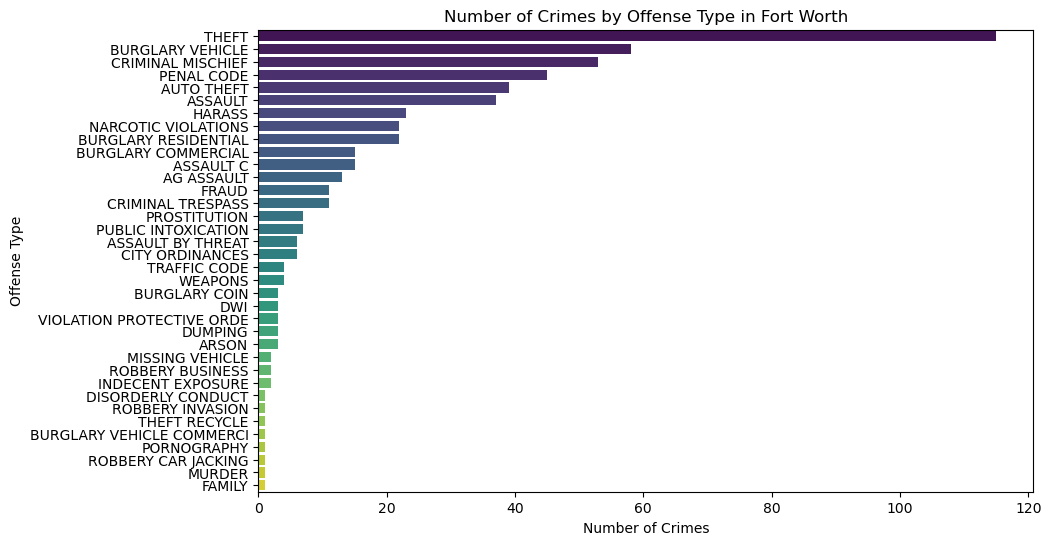

/var/folders/1x/d63v0p1x0t7cpz8_8l_1n7rm0000gn/T/ipykernel_30944/1687022308.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=division_counts.values, y=division_counts.index, palette='viridis')


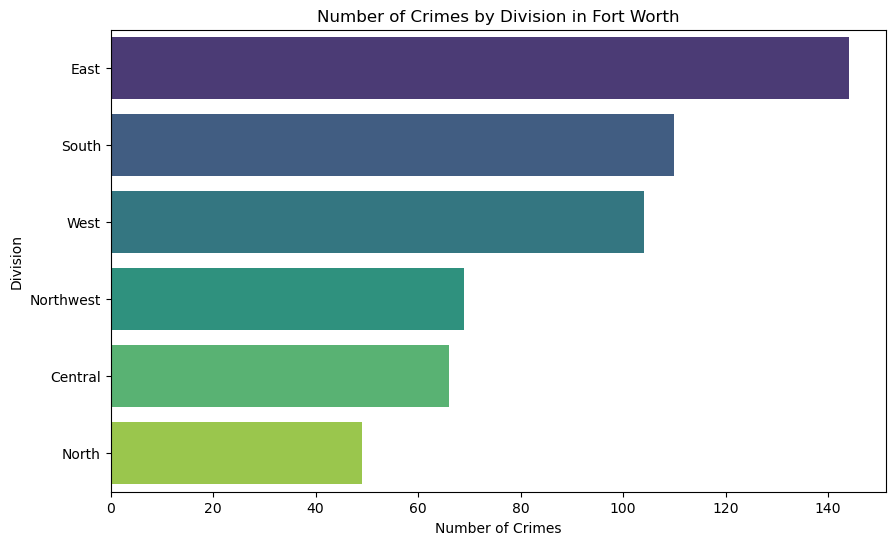

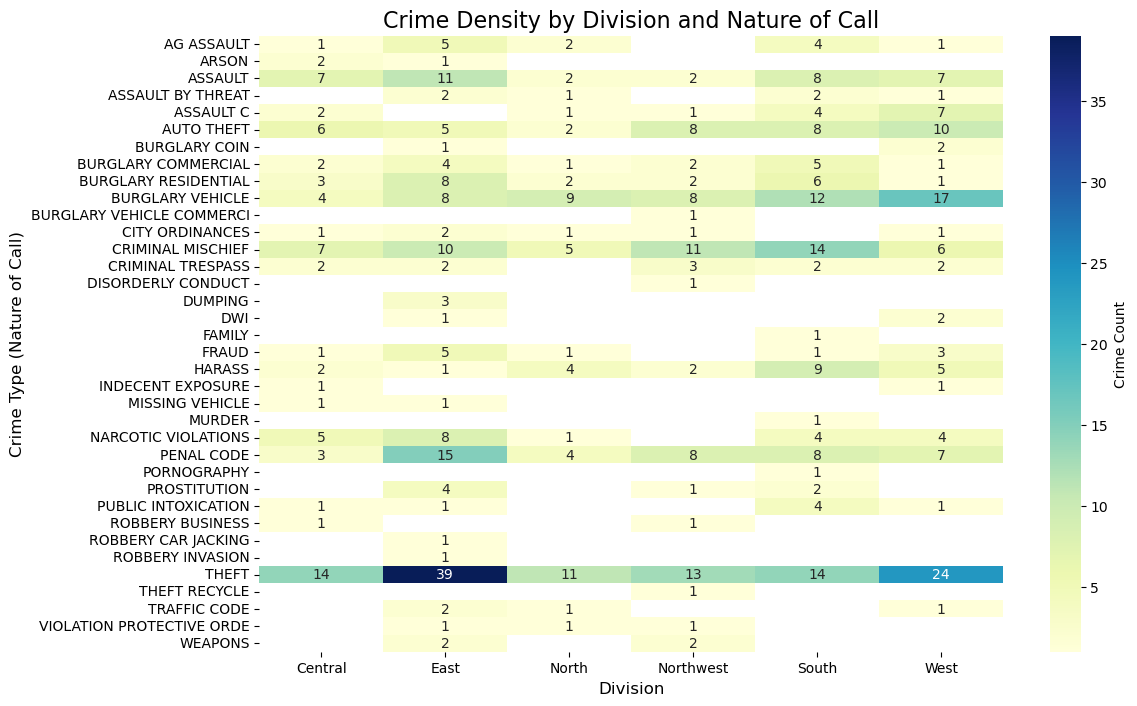

In [23]:
# 1. Bar chart: Number of Crimes by Offense Type (nature_of_call)
nature_of_call_counts = df['nature_of_call'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=nature_of_call_counts.values, y=nature_of_call_counts.index, palette='viridis')
plt.xlabel('Number of Crimes')
plt.ylabel('Offense Type')
plt.title('Number of Crimes by Offense Type in Fort Worth')
plt.show()

# 2. Bar chart: Number of Crimes by Division
division_counts = df['division'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=division_counts.values, y=division_counts.index, palette='viridis')
plt.xlabel('Number of Crimes')
plt.ylabel('Division')
plt.title('Number of Crimes by Division in Fort Worth')
plt.show()

# 3. Heatmap: Crime Density by Division and Nature of Call

# Count the number of occurrences for each combination of division and nature_of_call
crime_density = df.groupby(['division', 'nature_of_call']).size().reset_index(name='Count')

# Create a pivot table to summarize the number of occurrences by division and crime type
pivot = crime_density.pivot(index='nature_of_call', columns='division', values='Count')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Crime Count'})

# Set the title and labels
plt.title('Crime Density by Division and Nature of Call', fontsize=16)
plt.xlabel('Division', fontsize=12)
plt.ylabel('Crime Type (Nature of Call)', fontsize=12)

# Show the heatmap
plt.show()


From the crime data for Fort Worth we can see that the three divison with the lowest crime density is north, central, and nortwest. Since the worst crime is the East and South, the crimes seems to trends downward the further north and west in Fort Worth. According to Neighbhorhoodscout, the 10 Safest Fort Worth Area Neighborhoods in order: 

Lake of River Trails (East)
Haslet South (North)
Montserrat (West)
Avondale (North)
Pecan Acres (North)
Mira Vista (South)
Lakeside (West)
Villages of Woodland Springs East (North)
Pearson Ranch Rd / White Settlement Rd (West)
Heritage Northeast (North)

Due to this, the safest location to open would be in the north division of Fort Worth.

### Accessibility & Foot Traffic